In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
# from ipywidgets import *
from scipy.fft import fft,ifft,fftshift,ifftshift
import time
# import pylab as pl
# from IPython import display

%matplotlib inline

First thing to do, set the grid of your enviroment. The size and the spacing of your real space-grid will also define your k-vector space by 
\begin{equation}
    \Delta x \Delta k = \frac{2\pi}{N} \text{ .}
\end{equation}

In [2]:
grid_points = 1000       # points used in the calculation
dx = 0.1                # grid spacing in real sapce (1/sampling frequency)
dk = 2*np.pi/(dx*grid_points) # grid spacing in momentum space depends on gridpoints and sampling frequency

x = np.arange(-dx*np.floor(grid_points/2),dx*np.ceil(grid_points/2),dx)
k = np.linspace(-dk*np.floor(grid_points/2),dk*np.ceil(grid_points/2),grid_points,endpoint=False)

Now define your intial wavefunction of your BEC, for instance, you could use a gaussian wave packet.
- What would we measure in an actual experiment?
- Which contrainst would this function have?

In [3]:
x_0 = -10
sigma_x = 1
initial_wavefunction_r_space = 1/(2*np.pi*sigma_x**2)*np.exp(-(x-x_0)**2/(2*sigma_x**2))
probability_density_r_space = np.abs(initial_wavefunction_r_space)**2

print(np.sum(probability_density_r_space)*dx)

0.044896780531291015


We now want to have a look at our wavefunction in momentum space (k-space or Fourier space). To go there we will you the fft-package from the scipy module. (See initial import)
- Have look at the above defined constraints, do they still hold? Do we need to do something here?

In [4]:
initial_wavefunction_k_space = np.abs(fftshift(fft(initial_wavefunction_r_space)))**2

What would we see if we took a measurement of our wavefunction?

In [5]:
probability_density_r_space = np.abs(initial_wavefunction_r_space)**2
probability_density_k_space = np.abs(initial_wavefunction_k_space)**2
print(np.sum(probability_density_r_space)*dx)
print(np.sum(probability_density_k_space)*dx)

0.044896780531291015
505.26630069056074


Now we want to look at our defined wavefunction in both spaces. The following lines will plot the result, if everything is set right above.

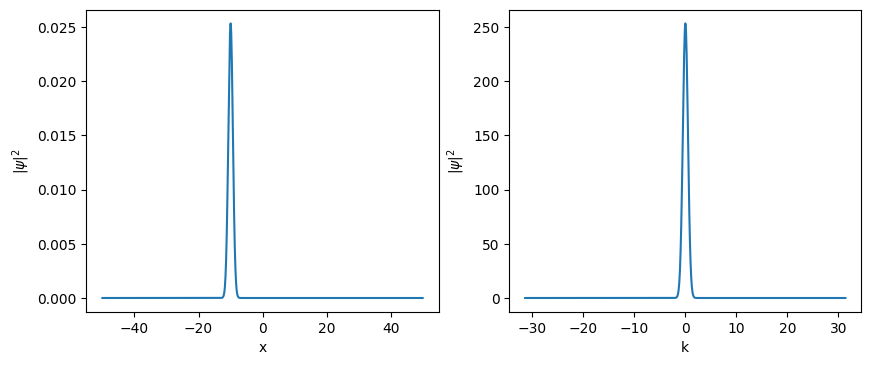

In [6]:
%matplotlib inline
fig_wfc = plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
ax_re = fig_wfc.add_subplot(121)
ax_mo = fig_wfc.add_subplot(122)

# real space
ax_re.plot(x,probability_density_r_space)
ax_re.set_xlabel("x")
ax_re.set_ylabel("$|\psi|^2$")


# momentum space
ax_mo.plot(k,probability_density_k_space)
ax_mo.set_xlabel("k")
ax_mo.set_ylabel("$|\psi|^2$")

plt.show()

Let's define a potential for our BEC and plot it. How about a harmonic potential for starters. Define it in a way that we can easily change the strength of the potenial

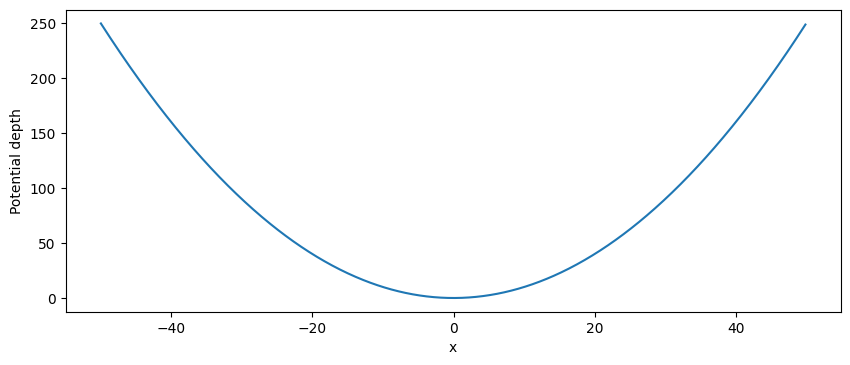

In [7]:
%matplotlib inline
omega = 0.1
potential = lambda omega: omega*x**2

fig_pot = plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
ax_pot = fig_pot.add_subplot(111)
ax_pot.plot(x,potential(omega))
ax_pot.set_xlabel("x")
ax_pot.set_ylabel("Potential depth")
plt.show()

Coming up next is the real work. We want to implement the split-step operator method.

Hamiltonian:
\begin{equation}\mathcal{H} = - \frac{\hbar^2}{2m}\nabla^2 + V(\mathbf{r}) + g |\psi (\mathbf{r},t)|^2\end{equation}

Separating real space and momentum space:
\begin{align}
\mathcal{H}_r  &= V(\mathbf{r}) + g |\psi (\mathbf{r},t)|^2 \\
\mathcal{H}_k  &= - \frac{\hbar^2}{2m}\mathbf{\nabla}^2 = \frac{\hat{\mathrm{p}}^2}{2m}
\end{align}

Using the split-step operator method we want to perform the time evolution as
\begin{equation}
\psi(\mathbf{r},t+dt) = \left[e^{-\frac{i\mathcal{H}_r dt}{2\hbar}}e^{-\frac{i\mathcal{H}_k dt}{\hbar}}e^{-\frac{i\mathcal{H}_r dt}{2\hbar}}\right]\psi(\mathbf{r},t) + \mathcal{O}(dt^3) \text{ .}
\end{equation}

Therefore, we need to define our operators $\mathcal{H}_r$ and $\mathcal{H}_k$ and time evolution operators $\mathcal{U}_r$ and $\mathcal{U}_k$.
- How do $\mathcal{U}_r$ and $\mathcal{U}_k$ look like?

In [15]:
g = 1
h_bar = 1
atom_mass = 1
dt = 0.05#*(-1j)
H_r = lambda wfc, omega: potential(omega)  + g * np.abs(wfc)**2
H_k = k**2/(2 * atom_mass)

U_r = lambda wfc, omega: np.exp(-1j*H_r(wfc,omega)*dt/(2*h_bar))
U_k = np.exp(-1j*H_k*dt/(h_bar))

Here, a plot is prepared where we can follow the evolution of the wavefunction.

<IPython.core.display.Javascript object>


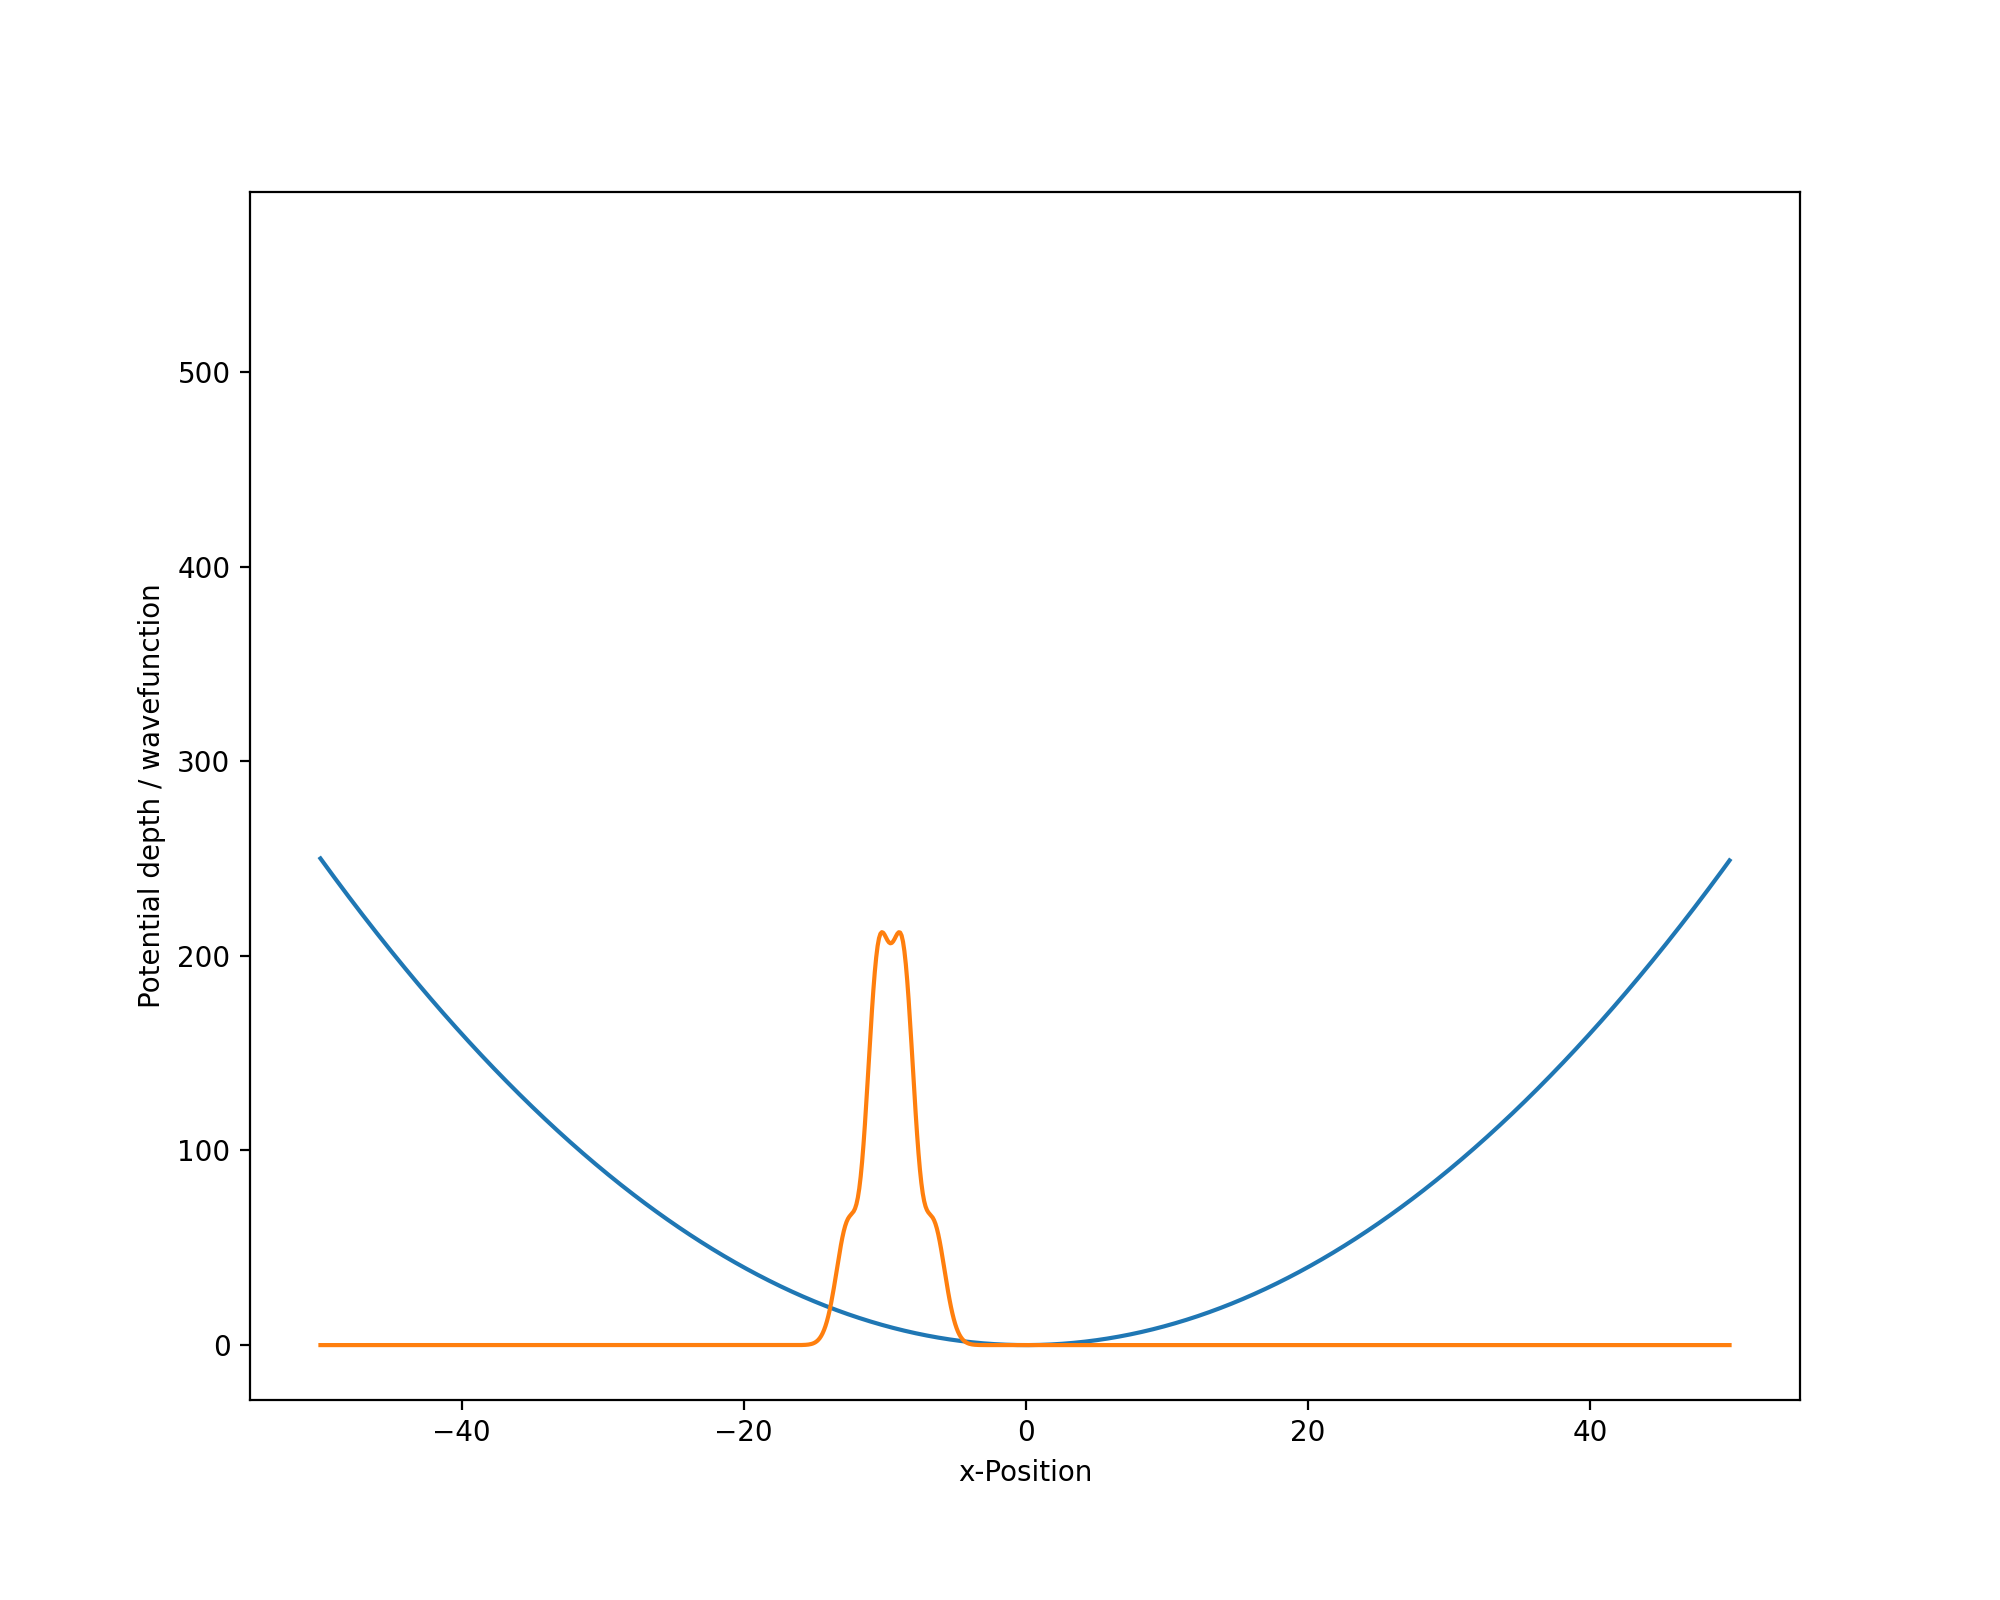

Text(0, 0.5, 'Potential depth / wavefunction')

In [19]:
%matplotlib notebook
wavefunction = initial_wavefunction_r_space
wavefunction = wavefunction/np.sqrt(np.sum(np.abs(wavefunction)**2)*dx)


# plt.ion()
fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.plot(x,potential(omega),x,np.abs(wavefunction)**2*1000)
ax.set_xlabel("x-Position")
ax.set_ylabel("Potential depth / wavefunction")
# plt.show()

In [20]:
for iTimestep in np.arange(1,2000):
    wavefunction = U_r(wavefunction,omega)*wavefunction
    wavefunction = fftshift(fft(wavefunction))
    wavefunction = U_k*wavefunction
    wavefunction = ifft(ifftshift(wavefunction))
    wavefunction = U_r(wavefunction,omega)*wavefunction
    wavefunction = wavefunction/np.sqrt(np.sum(np.abs(wavefunction)**2)*dx)
    if np.mod(iTimestep,20) == 0:
        ax.lines[1].set_ydata(np.abs(wavefunction)**2*1000)
        fig.canvas.draw()
        time.sleep(0.05)